# Tutorial 5: Labor search

The most-requested feature of SSJ toolkit v0.1 has been support for time-varying transition matrices for exogenous states in HA blocks. This is needed, for example, for models in which the probability of becoming unemployed varies with the business cycle. This feature is supported by HetBlocks in 1.0.0 and newer versions of the toolkit. In this notebook, we show how to implement it. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1 Model setup

Consider a simple incomplete markets model with unemployment risk. The state variables are 
- employment status $s \in \{E, U\}$
- labor productivity $e \in \{e_1, \dots, e_m\}$
- liquid assets $a \in [\underline{a}, \infty)$ 

Employment status matters for income. Employed workers earn wage $w_t e$, while unemployed workers receive benefits $b e.$ Let $y_t(s, e)$ denote this non-financial income.

From the workers' perspective, employment status evolves exogenously. An employed worker may lose her job with probability $\sigma_t$. An unemployed worker may find a job with probability $f_t.$ Let $\Pi_t^s$ denote the Markov matrix associated with state $s$. Of course, these transition probabilities may be determined endogenously outside the HetBlock, e.g. in a search and matching block.

The Bellman equation is
$$
\begin{align*}
V_t(s, e, a_{-}) = \max_{c, a} &\left\{\frac{c^{1-\sigma}}{1-\sigma} + \beta \mathbb{E}_t\left[V_{t+1}(s', e', a)|s, e \right] \right\}
\\
c + a &= (1 + r_t)a_{-} + y_t(s, e)
\\
a &\geq \underline{a}
\end{align*}
$$

## 2 Set up HA block

Starting in versio 1.0.0, HetBlocks support an arbitrary number of discrete exogenous state variables. The only restriction is on timing. We assume that when agents choose their endogenous state(s) (in this case assets $a$), all discrete shocks have already been resolved. The Bellman equation reflects this timing assumption. The relevant state is `(s, e, a_{-})`, i.e. `(s, e)` are from the current period, while `a_{-}` is from last period.

Some specific assumption on timing is necessary for the HetBlock to know how to take expectations with respect to exogenous states (backward iteration) and how to construct the law of motion for the distribution (forward iteration). The one we chose (discrete shocks before decisions) is the most common in the macro models.

In this paradigm, the HA problem we're dealing with is just a special case of SIM model that we used in the Krusell-Smith model. Compared to `sequence_jacobian/examples/hetblocks/household_sim`, we just need to make 3 small changes.
1. Make sure that numpy expressions work for 3-dimensional arrays (state space is `(s, e, a)` and not `(e, a)`).
2. Provide names of `exogenous` Markov matrices in *chronological order*.
3. Write hetinput function that maps job-finding and separation rates into the Markov matrix $\Pi_t^s$.

Once this is done. Everything will work as expected. We can shock and compute Jacobians with respect to $f_t$ and so on. 

#### Step 1: hetinputs 

In [2]:
from sequence_jacobian import markov_rouwenhorst, agrid

def make_grid(rho_e, sd_e, nE, amin, amax, nA):
    e_grid, _, Pi_e = markov_rouwenhorst(rho=rho_e, sigma=sd_e, N=nE)
    a_grid = agrid(amin=amin, amax=amax, n=nA)
    return e_grid, Pi_e, a_grid


def search_frictions(f, s):
    Pi_s = np.vstack(([1 - s, s], [f, 1 - f]))
    return Pi_s


def labor_income(e_grid, w, b):
    y = np.vstack((w * e_grid, b * e_grid))
    return y 

#### Step 2: core HA block

In [3]:
from sequence_jacobian import het, interpolate_y

def household_init(a_grid, y, r, eis):
    c = np.maximum(1e-8, y[..., np.newaxis] + np.maximum(r, 0.04) * a_grid)
    Va = (1 + r) * (c ** (-1 / eis))
    return Va

@het(exogenous=['Pi_s', 'Pi_e'], policy='a', backward='Va', backward_init=household_init)
def household(Va_p, a_grid, y, r, beta, eis):
    c_nextgrid = (beta * Va_p) ** (-eis)
    coh = (1 + r) * a_grid + y[..., np.newaxis]
    a = interpolate_y(c_nextgrid + a_grid, coh, a_grid)  # (x, xq, y)
    a = np.maximum(a, a_grid[0]) 
    c = coh - a
    uc = c ** (-1 / eis)
    Va = (1 + r) * uc

    return Va, a, c

#### Step 4: hetoutputs

Let's report the unemployment rate.

In [4]:
def unemployment(c):
    u = np.zeros_like(c)
    u[1, ...] = 1.0
    return u

#### Step 4: assemble HA block

In [5]:
hh = household.add_hetinputs([make_grid, search_frictions, labor_income])
hh = hh.add_hetoutputs([unemployment])

print(hh)
print(f'Inputs: {hh.inputs}')
print(f'Macro outputs: {hh.outputs}')
print(f'Micro outputs: {hh.internals}')

<HetBlock 'household' with hetinput 'search_frictions_labor_income' and with hetoutput `unemployment'>
Inputs: ['r', 'beta', 'eis', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'f', 's', 'w', 'b']
Macro outputs: ['A', 'C', 'U']
Micro outputs: ['D', 'Dbeg', 'Pi_s', 'Pi_e', 'Va', 'a', 'c', 'u', 'e_grid', 'a_grid', 'y']


## 3 Use HA block

Let's consider a baseline calibration and a shock to the separation rate.

In [6]:
calibration = dict(beta=0.95, r=0.01, eis=0.5, f=0.4, s=0.1, w=1., b=0.5,
                   rho_e=0.95, sd_e=0.5, nE=5, amin=0., amax=50, nA=100) 

ss = hh.steady_state(calibration)

c:\Users\thoma\anaconda3\lib\site-packages\sequence_jacobian\__init__.py:30: UserWarning: Calling sj.markov_rouwenhorst() is deprecated and will be disallowed in a subsequent version.
Please call sj.grids.markov_rouwenhorst() instead.
c:\Users\thoma\anaconda3\lib\site-packages\sequence_jacobian\__init__.py:25: UserWarning: The function 'agrid' is deprecated and will be removed in a subsequent version.
Please call sj.grids.asset_grid(amin, amax, n) instead.
c:\Users\thoma\anaconda3\lib\site-packages\sequence_jacobian\__init__.py:40: UserWarning: Calling sj.interpolate_y() is deprecated and will be disallowed in a subsequent version.
Please call sj.interpolate.interpolate_y() instead.
c:\Users\thoma\anaconda3\lib\site-packages\sequence_jacobian\__init__.py:40: UserWarning: Calling sj.interpolate_y() is deprecated and will be disallowed in a subsequent version.
Please call sj.interpolate.interpolate_y() instead.


Let's plot consumption function of worker with average productivity in employment vs unemployment.

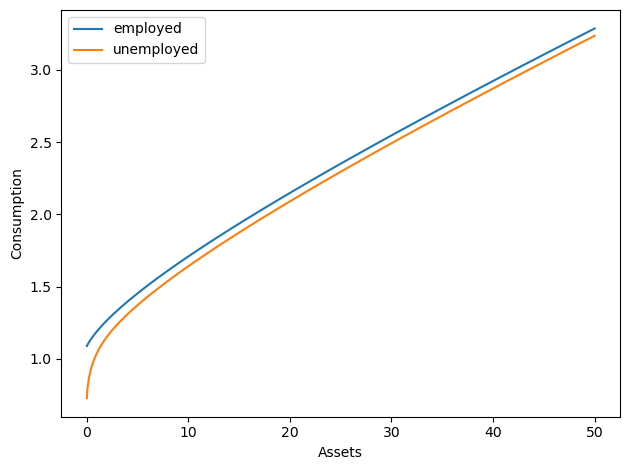

In [7]:
plt.plot(ss.internals['household']['a_grid'], ss.internals['household']['c'][0, 3, :], label='employed')
plt.plot(ss.internals['household']['a_grid'], ss.internals['household']['c'][1, 3, :], label='unemployed')
plt.xlabel('Assets')
plt.ylabel('Consumption')
plt.legend()
plt.tight_layout()
plt.show()

Consider the impulse responses of consumption end employment to a persistent rise in the separation rate.

In [8]:
td = hh.impulse_linear(ss, {'s': 0.6 ** np.arange(50)})

c:\Users\thoma\anaconda3\lib\site-packages\sequence_jacobian\__init__.py:40: UserWarning: Calling sj.interpolate_y() is deprecated and will be disallowed in a subsequent version.
Please call sj.interpolate.interpolate_y() instead.
c:\Users\thoma\anaconda3\lib\site-packages\sequence_jacobian\__init__.py:40: UserWarning: Calling sj.interpolate_y() is deprecated and will be disallowed in a subsequent version.
Please call sj.interpolate.interpolate_y() instead.


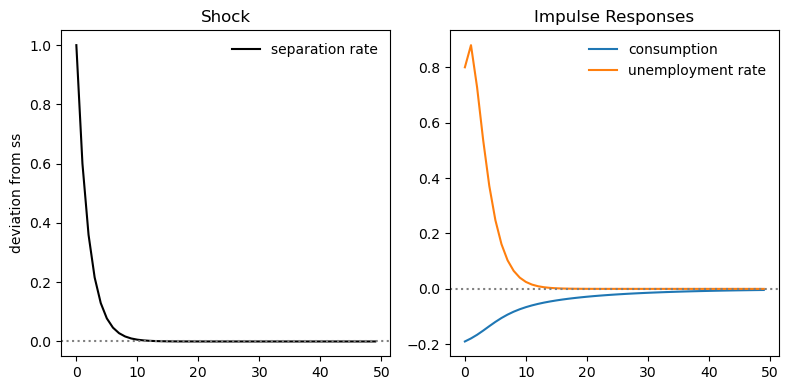

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.flatten()

ax[0].plot(td['s'], color='black', label='separation rate')
ax[0].axhline(0, color='gray', linestyle=':')
ax[0].set_title('Shock')
ax[0].set_ylabel('deviation from ss')
ax[0].legend(frameon=False)

ax[1].plot(td['C'], label='consumption')
ax[1].plot(td['U'], label='unemployment rate')
ax[1].axhline(0, color='gray', linestyle=':')
ax[1].legend(frameon=False)
ax[1].set_title('Impulse Responses')
plt.tight_layout()
plt.show()